# Collaborative Filtering for Movie Recommendations

## Introduction

In the era of information overload, recommendation systems have become crucial in helping users navigate vast amounts of content. This project focuses on implementing and analyzing a collaborative filtering system for movie recommendations using the MovieLens dataset.

Collaborative filtering is a technique that makes automatic predictions about the interests of a user by collecting preferences from many users. The core assumption is that if person A has the same opinion as person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.

In this project, we will:

1. Explore and preprocess the MovieLens dataset
2. Implement a collaborative filtering model using FastAI
3. Analyze the model's performance and predictions
4. Visualize the learned latent factors
5. Address challenges such as the cold start problem

Through this analysis, we aim to gain insights into user preferences, movie similarities, and the effectiveness of collaborative filtering in generating personalized recommendations.

# Loading the data

In [1]:
import pandas as pd

In [ ]:
### We downloaded a small sample of the MovieLens dataset: https://grouplens.org/datasets/movielens/
"""
This dataset (ml-latest-small) describes 5-star rating and free-text tagging
activity from [MovieLens](http://movielens.org), a movie recommendation service.
It contains 100836 ratings and 3683 tag applications across 9742 movies.
These data were created by 610 users between 1996 and 2018.
"""

In [ ]:
df_movies = pd.read_csv('movies.csv')
#Remove some title with multiple movieId
df_movies = df_movies.groupby('title')['movieId'].min().reset_index()
df_movies.head()

,title,movieId
0,'71 (2014),117867
1,'Hellboy': The Seeds of Creation (2004),97757
2,'Round Midnight (1986),26564
3,'Salem's Lot (2004),27751
4,'Til There Was You (1997),779


In [ ]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
#We just want to have a dataset with userID, movieId, rating, title
#So we'll join df_ratings and df_movies
df_main = pd.merge(df_ratings.drop(columns=['timestamp']), df_movies, on='movieId')
df_main.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [ ]:
print(df_main.describe())
print(df_main[['userId', 'movieId', 'title']].nunique())

              userId        movieId         rating
count  100830.000000  100830.000000  100830.000000
mean      326.131618   19430.333839       3.501567
std       182.616577   35523.902852       1.042548
min         1.000000       1.000000       0.500000
25%       177.000000    1199.000000       3.000000
50%       325.000000    2991.000000       3.500000
75%       477.000000    8118.750000       4.000000
max       610.000000  193609.000000       5.000000
userId      610
movieId    9719
title      9719
dtype: int64


We have 100 830 rows, with 610 users and 9719 movies

In [ ]:
df_main.groupby('userId')['rating'].count().reset_index().max()
#This user posted 2698 ratings!

userId     610
rating    2698
dtype: int64

In [ ]:
#We can also visualize the ratings for each user x movies with a Pivot table like this one

# Only shows the top 10 users and 10 movies in number of ratings
# Determine the top 10 users with the highest number of ratings
top_users = df_main['userId'].value_counts().nlargest(10).index
# Determine the top 10 movies with the highest number of ratings
top_movies = df_main['title'].value_counts().nlargest(10).index
# Filter the DataFrame to include only the top users and movies
filtered_df = df_main[df_main['userId'].isin(top_users) & df_main['title'].isin(top_movies)]

pivot_table = filtered_df.pivot(index='userId', columns='title', values='rating')

print(pivot_table)

title   Braveheart (1995)  Forrest Gump (1994)  Jurassic Park (1993)  \
userId                                                                 
68                    2.5                  3.5                   3.5   
274                   4.5                  4.5                   3.5   
288                   5.0                  5.0                   2.0   
380                   4.0                  5.0                   5.0   
414                   5.0                  5.0                   4.0   
448                   NaN                  3.0                   3.0   
474                   3.0                  3.0                   4.5   
599                   3.5                  3.5                   4.0   
606                   3.5                  4.0                   2.5   
610                   4.5                  3.0                   5.0   

title   Matrix, The (1999)  Pulp Fiction (1994)  Schindler's List (1993)  \
userId                                                     

# Building the Collaborative model with FastAI

In [ ]:
from fastai.collab import *

# Create the DataLoaders
dls = CollabDataLoaders.from_df(df_main, valid_pct=0.2, item_name='title', user_name='userId', rating_name='rating', bs=64)
"""
bs is batchsize
"""
dls.show_batch()


,userId,title,rating
0,480,Akira (1988),4.0
1,316,What Lies Beneath (2000),3.0
2,68,Terminator 3: Rise of the Machines (2003),3.0
3,475,Monsters University (2013),3.0
4,474,Less Than Zero (1987),3.0
5,606,Pride & Prejudice (2005),3.5
6,590,Meet Joe Black (1998),3.5
7,432,Gran Torino (2008),4.0
8,606,"Man in the Iron Mask, The (1998)",4.0
9,480,Austin Powers in Goldmember (2002),4.0


In [ ]:
# Define the model
learn = collab_learner(dls, n_factors=50, y_range=(0.5, 5.5))
"""
n_factors is the number of latent factors to use in the embedding matrices
y_range gives the range of possible values for the ratings
"""

# Train the model
learn.fit_one_cycle(5, 5e-3)
"""
5 epochs
5e-3 learning rate
Our loss function is MSE by default
"""

# Save the model
learn.save('collab_model_v1')

epoch,train_loss,valid_loss,time
0,0.714936,0.813243,00:10
1,0.403656,0.786738,00:08
2,0.259812,0.804461,00:09
3,0.182695,0.809045,00:09
4,0.163325,0.809426,00:09


Path('models/collab_model_v1.pth')

## We can see that the train loss decreased but the valid loss is still high - which is an indicator of overfitting. Let's add some L2 regularization to try to compensate this

In [ ]:
# Define the model
learn = collab_learner(dls, n_factors=50, y_range=(0.5, 5.5))
# Train the model
learn.fit_one_cycle(5, 5e-3, wd=0.3)
"""
5 epochs
5e-3 learning rate
weight decay of 0.1 to perform L2 regularization in order to avoid overfitting
When doing L2 regularization, we add to the loss function the sum of all the weights squared,
so that the gradient descent forces them to be as small as possible which will reduce overfitting
"""

# Save the model
learn.save('collab_model_v2')

epoch,train_loss,valid_loss,time
0,0.756166,0.836628,00:08
1,0.629876,0.795439,00:09
2,0.584808,0.771581,00:09
3,0.524082,0.755854,00:08
4,0.523823,0.748980,00:09


Path('models/collab_model_v2.pth')

## It's a bit better on the validating loss

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

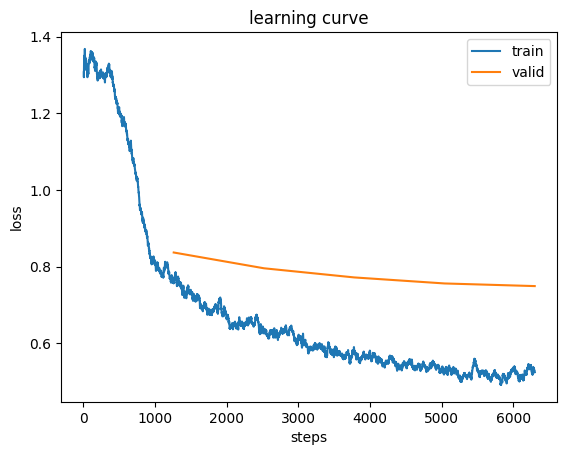

In [ ]:
#We can plot the loss evolution
learn.recorder.plot_loss()

## This model is not deep learning, it is simply solving a matrix factorization problem.
## We compute dot products between user and movies latent factors and try to have a prediction of Ratings as close as possible as the truth. We evaluate with MSE

## Biases are added which are additional parameters introduced to account for systematic tendencies in the data that cannot be captured by the latent factors alone.

In [ ]:
"""
Now let's see what happens when we split by user_id instead of the default split
It'll allow us to simulate a Cold Start situation, where we would need to predict
for a new user
"""
from fastai.collab import *
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split


# Split the data by user_id
unique_users = df_main['userId'].unique()
train_users, valid_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_df = df_main[df_main['userId'].isin(train_users)]
valid_df = df_main[df_main['userId'].isin(valid_users)]


# Create the DataLoaders
dls = CollabDataLoaders.from_df(train_df, valid_pct=0.0, item_name='title', user_name='userId', rating_name='rating', bs=64)
# Create a separate validation DataLoader
valid_dls = CollabDataLoaders.from_df(valid_df, valid_pct=0.0, user_name='userId', item_name='title', rating_name='rating', bs=64)
# Manually set the validation DataLoader
dls.valid = valid_dls.train

"""
bs is batchsize
"""
dls.show_batch()

"""
We can verify that the users are split 20% / 80% in the training and validating
"""
print(dls.valid_ds['userId'].nunique())
print(dls.train_ds['userId'].nunique())

# Define the model
learn = collab_learner(dls, n_factors=50, y_range=(0.5, 5.5))
# Train the model
learn.fit_one_cycle(5, 5e-3, wd=0.3)
# Save the model
learn.save('collab_model_vsplit_user')

,userId,title,rating
0,264,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),1.0
1,34,X-Men (2000),5.0
2,275,Men in Black (a.k.a. MIB) (1997),3.0
3,580,Babylon 5: A Call to Arms (1999),3.0
4,432,21 Grams (2003),3.0
5,116,Grease (1978),4.5
6,474,"Blues Brothers, The (1980)",3.0
7,587,Sleeper (1973),4.0
8,135,"Shawshank Redemption, The (1994)",5.0
9,323,Interview with the Vampire: The Vampire Chronicles (1994),4.0


122
488


epoch,train_loss,valid_loss,time
0,0.744795,1.253535,00:09
1,0.619640,1.273222,00:08
2,0.559925,1.273130,00:08
3,0.509538,1.240849,00:09
4,0.514583,1.258239,00:09


Path('models/collab_model_vsplit_user.pth')

## We can see that in the case of users the models has never seen, the accuracy is worse. This is a classic example of a Cold Start problem. This issue could be solved by asking the user about type of movies it likes at the beginning of its experience

In [ ]:
#Ok now let's try to use a Neural network with our FastAI model

# Data Loaders
dls = CollabDataLoaders.from_df(df_main, valid_pct=0.2, item_name='title', user_name='userId', rating_name='rating', bs=64)
# Define the model
learn = collab_learner(dls, n_factors=50, y_range=(0.5, 5.5), use_nn=True)
# Train the model
learn.fit_one_cycle(5, 5e-3, wd=0.3)
"""
5 epochs
5e-3 learning rate
weight decay of 0.1 to perform L2 regularization in order to avoid overfitting
When doing L2 regularization, we add to the loss function the sum of all the weights squared,
so that the gradient descent forces them to be as small as possible which will reduce overfitting
"""

# Save the model
learn.save('collab_model_v3')

epoch,train_loss,valid_loss,time
0,0.768877,0.867542,00:09
1,0.730715,0.835493,00:10
2,0.718273,0.807265,00:10
3,0.621000,0.785465,00:10
4,0.575705,0.784256,00:10


Path('models/collab_model_v3.pth')

## Performances are quite close to the non neural net model!

# Use the model

## Let's user our best model to predict some ratings for one of our user

In [ ]:
# Load the model (if needed)
learn = collab_learner(dls, n_factors=50, y_range=(0.5, 5.5), use_nn=False)
learn.load('collab_model_v2')

#We can test our model by asking it to predict some ratings for some movies x userId

# Given userId and title
user_id = 448
# Let's take a 100 random movies
import random
random.seed(42)
title = random.sample(list(df_main['title'].unique()), 100)

# Create a dataframe with pairs [user_id, movie_id]
df = pd.DataFrame({
    'userId': [user_id] * len(title),
    'title': title
})


# Convert it to DataLoader and make predictions
dl = learn.dls.test_dl(df)
preds = learn.get_preds(dl=dl)

# Merge predictions with movie ids
preds_df = pd.DataFrame({
    'userId': user_id,
    'item': title,
    'prediction': preds[0].numpy().flatten()
}).sort_values('prediction', ascending=False)

print(preds_df)

    userId                                         item  prediction
85     448                           The Martian (2015)    3.704934
84     448  Louis C.K.: Live at The Comedy Store (2015)    3.674461
95     448                        Cinderella Man (2005)    3.633207
13     448                                    Pi (1998)    3.621608
46     448        Dr. Horrible's Sing-Along Blog (2008)    3.584472
..     ...                                          ...         ...
58     448                     Universal Soldier (1992)    2.159982
60     448                            Wanderlust (2012)    2.125079
26     448       I Know What You Did Last Summer (1997)    2.053203
63     448                  D3: The Mighty Ducks (1996)    2.049739
73     448   Remo Williams: The Adventure Begins (1985)    2.040301

[100 rows x 3 columns]


In [ ]:
#Let's join with the true rating in case the user has some true rating
df_truth = df_main[df_main['userId']==user_id]
df_truth = df_truth.rename(columns={'rating':'true_rating', 'title':'item'})

df_pred_truth = pd.merge(preds_df, df_truth[['item','true_rating']], on='item', how='left')
print(df_pred_truth)
print(df_pred_truth['true_rating'].isna().sum()) #Number of prediction where we don't have the truth

    userId                                         item  prediction  \
0      448                           The Martian (2015)    3.704934   
1      448  Louis C.K.: Live at The Comedy Store (2015)    3.674461   
2      448                        Cinderella Man (2005)    3.633207   
3      448                                    Pi (1998)    3.621608   
4      448        Dr. Horrible's Sing-Along Blog (2008)    3.584472   
..     ...                                          ...         ...   
95     448                     Universal Soldier (1992)    2.159982   
96     448                            Wanderlust (2012)    2.125079   
97     448       I Know What You Did Last Summer (1997)    2.053203   
98     448                  D3: The Mighty Ducks (1996)    2.049739   
99     448   Remo Williams: The Adventure Begins (1985)    2.040301   

    true_rating  
0           4.0  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
95          NaN  
96 

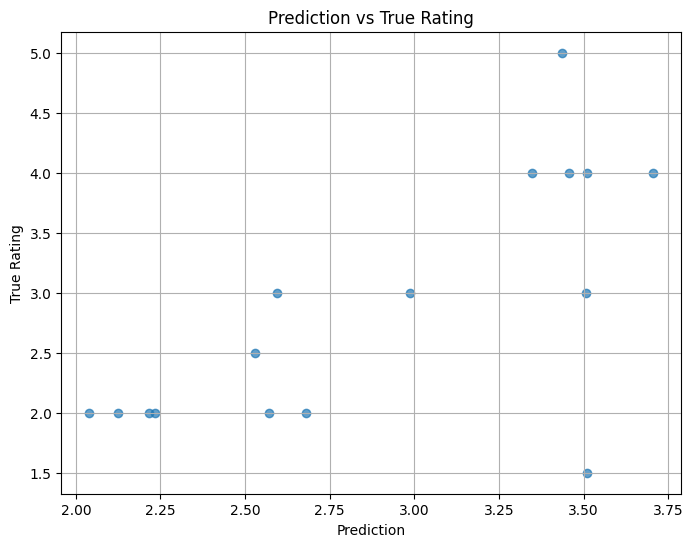

In [ ]:
#Plotting the prediction vs true rating
import matplotlib.pyplot as plt

# Creating the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_pred_truth['prediction'], df_pred_truth['true_rating'], alpha=0.7)
plt.title('Prediction vs True Rating')
plt.xlabel('Prediction')
plt.ylabel('True Rating')
plt.grid(True)
plt.show()

and let's see the top recommended movies for our user

In [ ]:
df_pred_truth.sort_values(by='prediction', ascending=False).head(5)

,userId,item,prediction,true_rating
0,448,The Martian (2015),3.704934,4.0
1,448,Louis C.K.: Live at The Comedy Store (2015),3.674461,NaN
2,448,Cinderella Man (2005),3.633207,NaN
3,448,Pi (1998),3.621608,NaN
4,448,Dr. Horrible's Sing-Along Blog (2008),3.584472,NaN


## What if we now have a new user?

In [ ]:
#What if we now have a new user?

# Given userId and title
user_id = 'New User'
# Let's take a 100 random movies
import random
random.seed(42)
title = random.sample(list(df_main['title'].unique()), 100)

# Create a dataframe with pairs [user_id, movie_id]
df = pd.DataFrame({
    'userId': [user_id] * len(title),
    'title': title
})


# Convert it to DataLoader and make predictions
dl = learn.dls.test_dl(df)
preds = learn.get_preds(dl=dl)

# Merge predictions with movie ids
preds_df = pd.DataFrame({
    'userId': user_id,
    'item': title,
    'prediction': preds[0].numpy().flatten()
}).sort_values('prediction', ascending=False)

print(preds_df)

      userId                                         item  prediction
85  New User                           The Martian (2015)    3.203151
95  New User                        Cinderella Man (2005)    3.180944
13  New User                                    Pi (1998)    3.160828
84  New User  Louis C.K.: Live at The Comedy Store (2015)    3.133427
51  New User                             Clerks II (2006)    3.120352
..       ...                                          ...         ...
73  New User   Remo Williams: The Adventure Begins (1985)    2.921587
59  New User                       Beethoven's 2nd (1993)    2.905281
58  New User                     Universal Soldier (1992)    2.900322
63  New User                  D3: The Mighty Ducks (1996)    2.899253
26  New User       I Know What You Did Last Summer (1997)    2.819765

[100 rows x 3 columns]


## We can make some predictions for this new user! But as we've seen earlier, these predictions won't be so accurate, so to solve the Cold Start problem we'd have to dig deeper in further solutions like asking a survey at the beginning etc.

## Finally, let's take 2 of the latent factors our model has learned, and plot them on a graph

In [ ]:
#Let's keep the top 100 movies
g = df_main.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:100]
top_movies[:10]

array(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Jurassic Park (1993)', 'Braveheart (1995)',
       'Terminator 2: Judgment Day (1991)', "Schindler's List (1993)"],
      dtype=object)

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([100, 50])

In [ ]:
#We run some PCA to reduce the dimensions
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([100, 3])

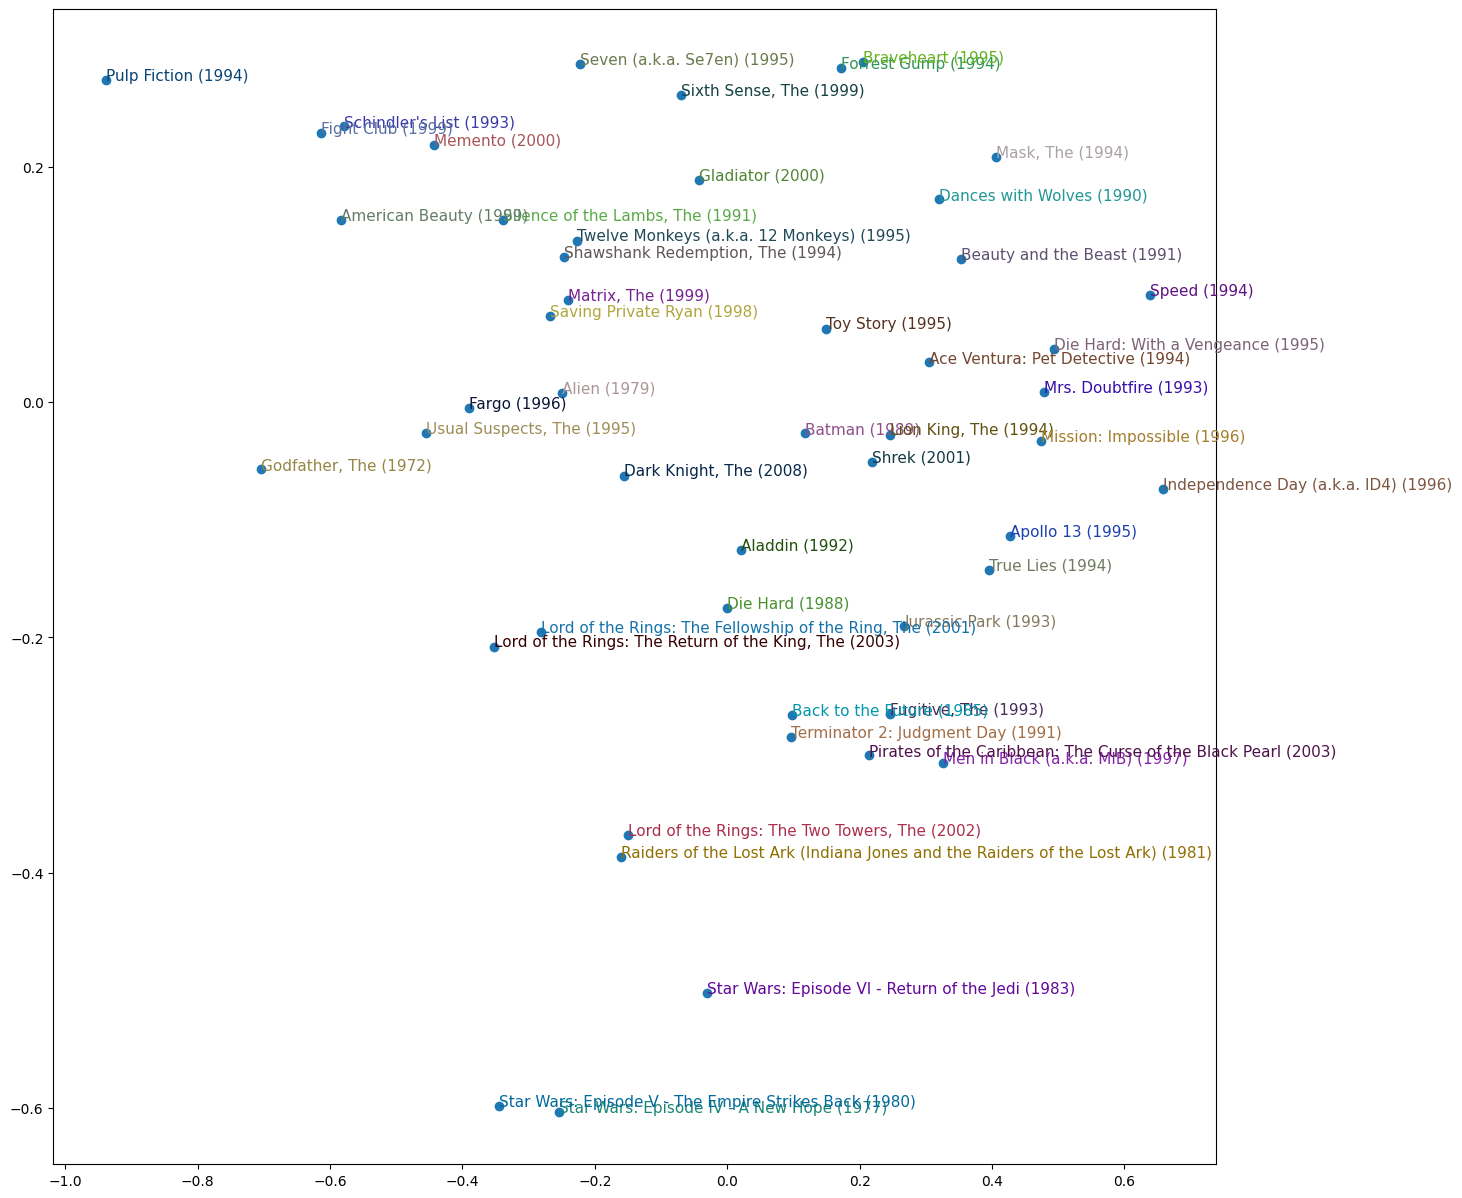

In [ ]:
#And we can plot our movies on 2 dimensions of weights
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## We can see that with only these 2 dimensions, we can already identify some clusters of movies!

## Conclusion

This project has demonstrated the implementation and analysis of a collaborative filtering system for movie recommendations. We've successfully built and trained models using both matrix factorization and neural network approaches, achieving reasonable predictive performance on our dataset.

However, there's still room for improvement. Here are detailed potential next steps for further development:

1. Advanced Model Architectures:
   - Implement hybrid models combining collaborative filtering with content-based approaches
   - Explore sequence-aware recommenders to capture temporal dynamics in user preferences
   - Investigate deep learning architectures like autoencoders or graph neural networks for recommendation

2. Hyperparameter Optimization:
   - Conduct systematic hyperparameter tuning using techniques like Bayesian optimization
   - Implement automated machine learning (AutoML) for model selection and optimization

3. Feature Engineering:
   - Incorporate additional features like user demographics, movie genres, or textual reviews
   - Develop time-aware features to capture evolving user preferences and item popularity

4. Evaluation and Metrics:
   - Implement additional evaluation metrics such as NDCG, MAP, or diversity measures
   - Conduct A/B testing to evaluate model performance in real-world scenarios

5. Cold Start and Long Tail:
   - Further refine strategies for new users and items, such as meta-learning approaches
   - Develop techniques to improve recommendations for long-tail (less popular) items